In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
import pandas as pd

**First, download data from:**

https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view

and save the downloaded data1 folder in the current directory.

In [2]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

**Visualize a single segmentation image**

In this data, there are 12 segmentation classes and the image is from a driving car.

0006R0_f02490.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


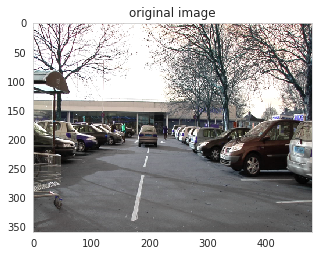

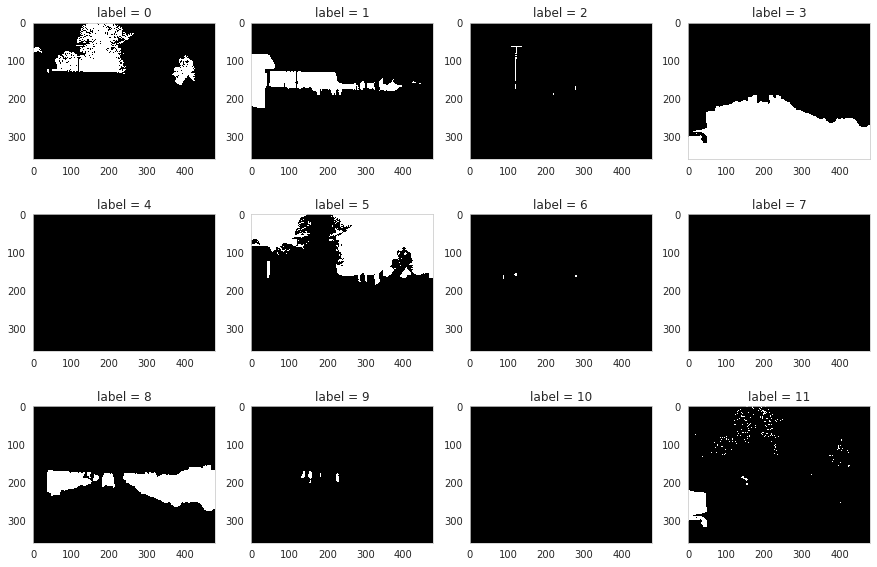

In [3]:
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


plt.show()

**Data preprocessing: Resize image**

To simplify the problem, I will reshape all the images to the same size: (224,224). 
Why (224,224)? 
This is the iamge shape used in VGG and FCN model in this blog uses a network that takes advantage of VGG structure. 
The FCN model becomes easier to explain when the image shape is (224,224). 
However, FCN does not requires the image shape to be (224,224).

Let's visualize how the resizing make the images look like. The images look fine.

In [4]:
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

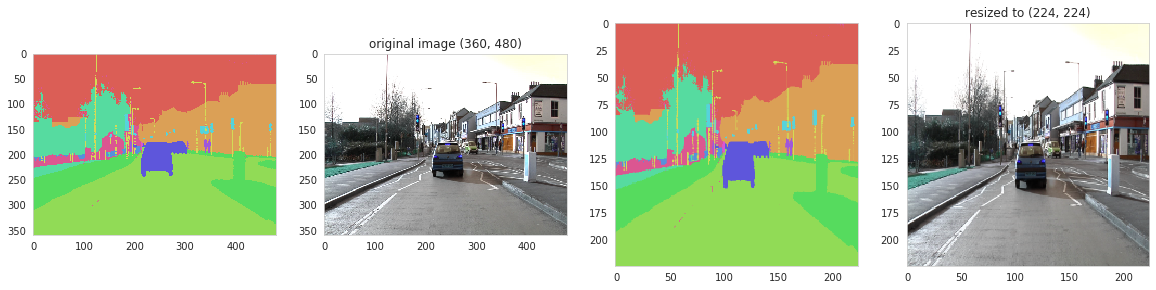

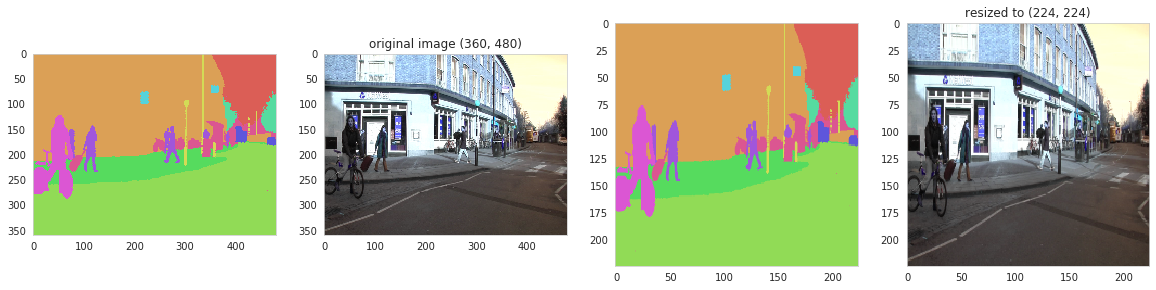

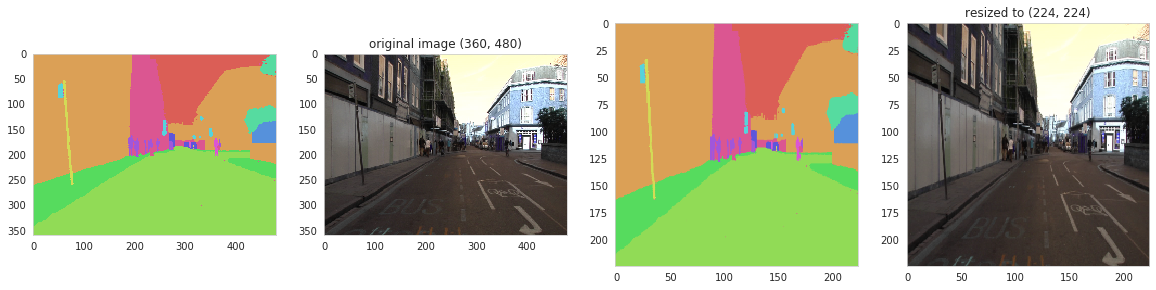

In [5]:
input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [6]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

Resize all the images. We have 367 images in this dataset

In [7]:
images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


Import Keras and Tensorflow to develop deep learning FCN models

In [8]:
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras import optimizers

/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages

In [9]:
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
keras version 2.2.4
tensorflow version 1.12.0


In [10]:
## location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

**Homework** ->
Make FCN8 based on FCN16

In [11]:
def FCN16(nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    ## con7: (7, 7, 4096), wanna transpose to (14, 14, 12) 
    conv7_2 = Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 14, 14, 12), 2 times upsampling by transpose convolution
    ## 12 means the number of 'Classes'
    
    ## pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    ## (None, 14, 14, 12) for upsampling x16
    
    ## pool311
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
    ## (None, 28, 28, 12) for upsampling x8
    
    
    o = Add(name="add")([pool411, conv7_2])
    # (classes number, 14,14,12)
    o = Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    # (classes number, 28,28,12), 2 times upsampling by transpose convolution
    # wanna make FCN-8s (Fully Connectional Network by 8(up)sampling)
    
    o = Add(name="add2")([pool311, o])
    # o: (28, 28, 12)
    
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) , strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    # 8 x 28 = 224
    # o: (224, 224, 12)
    
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

In [12]:
model = FCN16(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

Split between training and testing data

In [13]:
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


**Training starts here**

In [14]:
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=250)

Train on 311 samples, validate on 56 samples
Epoch 1/250
311/311 [==============================] - 22s 71ms/step - loss: 2.5828 - acc: 0.0896 - val_loss: 2.4835 - val_acc: 0.0914
Epoch 2/250
311/311 [==============================] - 8s 25ms/step - loss: 2.4820 - acc: 0.0936 - val_loss: 2.4796 - val_acc: 0.0981
Epoch 3/250
311/311 [==============================] - 8s 25ms/step - loss: 2.4772 - acc: 0.0999 - val_loss: 2.4728 - val_acc: 0.1052
Epoch 4/250
311/311 [==============================] - 8s 25ms/step - loss: 2.4670 - acc: 0.1111 - val_loss: 2.4561 - val_acc: 0.1216
Epoch 5/250
311/311 [==============================] - 8s 25ms/step - loss: 2.4400 - acc: 0.1338 - val_loss: 2.4082 - val_acc: 0.1562
Epoch 6/250
311/311 [==============================] - 8s 25ms/step - loss: 2.3583 - acc: 0.1823 - val_loss: 2.2704 - val_acc: 0.2304
Epoch 7/250
311/311 [==============================] - 8s 25ms/step - loss: 2.1849 - acc: 0.2669 - val_loss: 2.0305 - val_acc: 0.3077
Epoch 8/250
311/

311/311 [==============================] - 8s 25ms/step - loss: 0.6235 - acc: 0.8166 - val_loss: 0.7399 - val_acc: 0.7875
Epoch 62/250
311/311 [==============================] - 8s 25ms/step - loss: 0.6214 - acc: 0.8188 - val_loss: 0.6473 - val_acc: 0.8141
Epoch 63/250
311/311 [==============================] - 8s 25ms/step - loss: 0.6088 - acc: 0.8230 - val_loss: 0.6633 - val_acc: 0.8083
Epoch 64/250
311/311 [==============================] - 8s 25ms/step - loss: 0.6047 - acc: 0.8233 - val_loss: 0.6492 - val_acc: 0.8124
Epoch 65/250
311/311 [==============================] - 8s 25ms/step - loss: 0.6000 - acc: 0.8252 - val_loss: 0.6489 - val_acc: 0.8139
Epoch 66/250
311/311 [==============================] - 8s 25ms/step - loss: 0.6060 - acc: 0.8234 - val_loss: 0.6412 - val_acc: 0.8168
Epoch 67/250
311/311 [==============================] - 8s 25ms/step - loss: 0.5950 - acc: 0.8269 - val_loss: 0.6383 - val_acc: 0.8179
Epoch 68/250
311/311 [==============================] - 8s 25ms/step

311/311 [==============================] - 8s 25ms/step - loss: 0.5254 - acc: 0.8504 - val_loss: 0.5653 - val_acc: 0.8417
Epoch 122/250
311/311 [==============================] - 8s 25ms/step - loss: 0.5033 - acc: 0.8570 - val_loss: 0.5587 - val_acc: 0.8427
Epoch 123/250
311/311 [==============================] - 8s 25ms/step - loss: 0.5013 - acc: 0.8579 - val_loss: 0.5640 - val_acc: 0.8420
Epoch 124/250
311/311 [==============================] - 8s 25ms/step - loss: 0.5004 - acc: 0.8581 - val_loss: 0.5599 - val_acc: 0.8427
Epoch 125/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4988 - acc: 0.8586 - val_loss: 0.5614 - val_acc: 0.8422
Epoch 126/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4988 - acc: 0.8585 - val_loss: 0.5587 - val_acc: 0.8435
Epoch 127/250
311/311 [==============================] - 8s 25ms/step - loss: 0.5006 - acc: 0.8579 - val_loss: 0.5712 - val_acc: 0.8400
Epoch 128/250
311/311 [==============================] - 8s 25

311/311 [==============================] - 8s 25ms/step - loss: 0.4554 - acc: 0.8723 - val_loss: 0.5282 - val_acc: 0.8521
Epoch 182/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4588 - acc: 0.8714 - val_loss: 0.5287 - val_acc: 0.8524
Epoch 183/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4537 - acc: 0.8727 - val_loss: 0.5292 - val_acc: 0.8519
Epoch 184/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4520 - acc: 0.8732 - val_loss: 0.5302 - val_acc: 0.8526
Epoch 185/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4609 - acc: 0.8707 - val_loss: 0.5300 - val_acc: 0.8516
Epoch 186/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4529 - acc: 0.8731 - val_loss: 0.5291 - val_acc: 0.8522
Epoch 187/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4507 - acc: 0.8739 - val_loss: 0.5268 - val_acc: 0.8532
Epoch 188/250
311/311 [==============================] - 8s 25

311/311 [==============================] - 8s 25ms/step - loss: 0.4259 - acc: 0.8816 - val_loss: 0.5122 - val_acc: 0.8573
Epoch 242/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4261 - acc: 0.8814 - val_loss: 0.5117 - val_acc: 0.8576
Epoch 243/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4274 - acc: 0.8809 - val_loss: 0.5166 - val_acc: 0.8563
Epoch 244/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4343 - acc: 0.8785 - val_loss: 0.5116 - val_acc: 0.8579
Epoch 245/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4238 - acc: 0.8822 - val_loss: 0.5109 - val_acc: 0.8580
Epoch 246/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4240 - acc: 0.8821 - val_loss: 0.5111 - val_acc: 0.8584
Epoch 247/250
311/311 [==============================] - 8s 25ms/step - loss: 0.4239 - acc: 0.8821 - val_loss: 0.5110 - val_acc: 0.8579
Epoch 248/250
311/311 [==============================] - 8s 25

Plot the change in loss over epochs

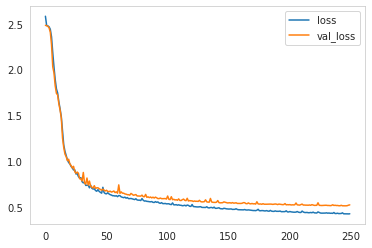

In [15]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

Calculate intersection over union for each segmentation class

In [16]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(56, 224, 224) (56, 224, 224)


In [17]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))

In [18]:
IoU(y_testi,y_predi)

class 00: #TP=411830, #FP= 51624, #FN=16504, IoU=0.858
class 01: #TP=628194, #FP=130432, #FN=44149, IoU=0.783
class 02: #TP=     9, #FP=   253, #FN=30852, IoU=0.000
class 03: #TP=866069, #FP= 47417, #FN=30869, IoU=0.917
class 04: #TP= 87542, #FP= 37809, #FN=41040, IoU=0.526
class 05: #TP=196018, #FP= 47536, #FN=60434, IoU=0.645
class 06: #TP=    89, #FP=   165, #FN=37624, IoU=0.002
class 07: #TP= 10659, #FP=  8429, #FN=25704, IoU=0.238
class 08: #TP=162651, #FP= 45555, #FN=33471, IoU=0.673
class 09: #TP=   243, #FP=   392, #FN=22698, IoU=0.010
class 10: #TP=   228, #FP=   353, #FN=13798, IoU=0.016
class 11: #TP= 39633, #FP= 36726, #FN=49548, IoU=0.315
_________________
Mean IoU: 0.415


**Visualize the model performance**


Looks reasonable!

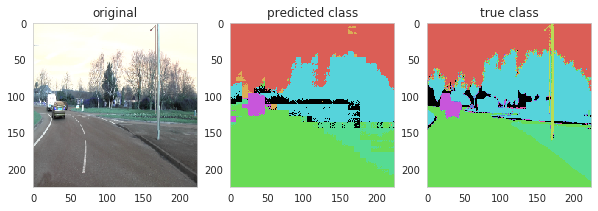

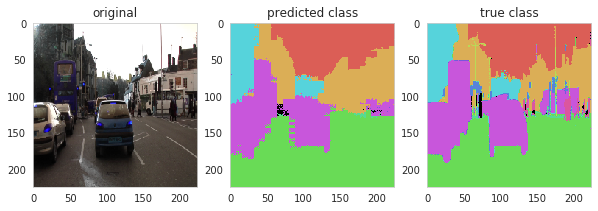

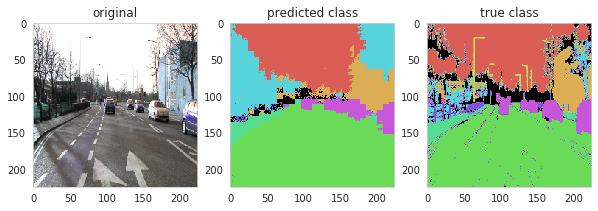

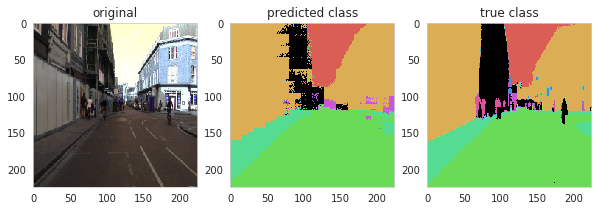

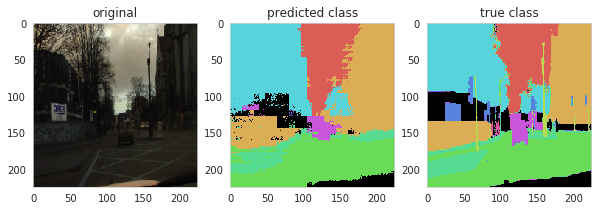

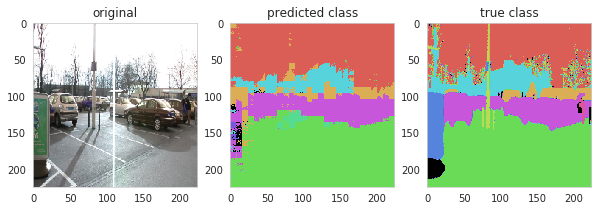

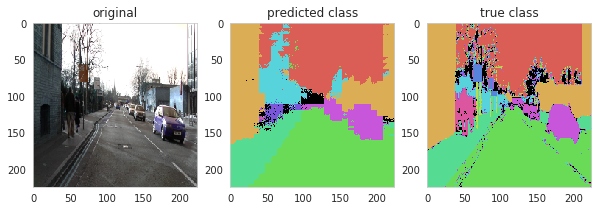

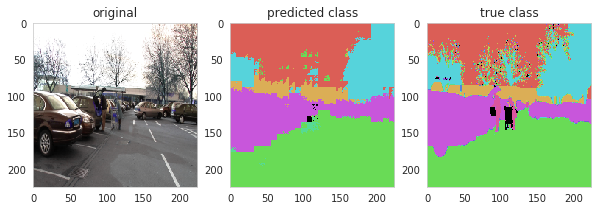

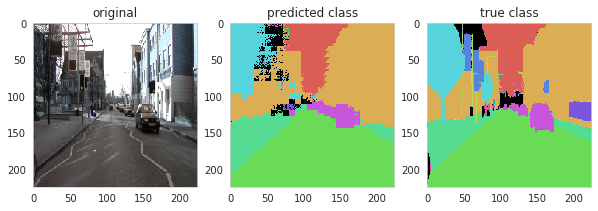

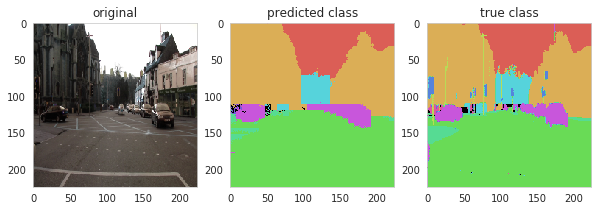

In [19]:
shape = (224,224)
n_classes= 10

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()